# Goal: Build a dataset
Input:
* List of buoys
* List of years

In [1]:
import sys
import os
import traceback

import numpy as np
from IPython.core.display_functions import display

dir_root =os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
sys.path.append(dir_root)
import myLibrary as mL

import cdsapi
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import netCDF4 as nc
import seaborn as sns
import time
import traceback

---
# Input Parameters:

In [2]:
STATION_LIST = [
    '41117',
    '41112',
    '42001',
    '42002',
    '42012'
]

YEARS = [
    '2019',
    '2020',
    '2021',
    '2022'
]

filename = "dataset1"

In [5]:
#Complete data in Gulf of Mexico
STATION_LIST = mL.cleaned_stations_GOM
YEARS = [str(i) for i in list(range(1970,2023))]
filename = "dataset_GOM_all"

print("Number of stations: ", len(STATION_LIST))
print("Number of years: ", len(YEARS))
print("Number of files: ", len(STATION_LIST)*len(YEARS))

Number of stations:  123
Number of years:  53
Number of files:  6519


---

In [6]:
metadata = pd.read_csv('../data/metadata/metadata_2023_03_14.csv')
metadata = metadata.set_index("StationID")

In [7]:
# create the new dataframe filled with False values
file_availability = pd.DataFrame(
    [[False for _ in range(len(YEARS))] for _ in range(len(STATION_LIST))],
    index=STATION_LIST,
    columns=YEARS
)

# loop through all cells of the dataframe
for index, row in file_availability.iterrows():
    for column in file_availability.columns:
        try:
            file_availability.loc[index, column] = metadata.loc[index, column]
            #print("Station found!")
        except KeyError:
            print(f"Station {index} does not provide any files! ")
            break

file_availability

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
41117,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
41112,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
42001,False,False,False,False,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
42002,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
42012,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VCAT2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
VENF1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
WIWF1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
WPLF1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True


In [10]:
print("Number of available files: ",file_availability.sum().sum())
print("Number of unavailable files: ", len(STATION_LIST)*len(YEARS)-file_availability.sum().sum())

Number of available files:  1806
Number of unavailable files:  4713


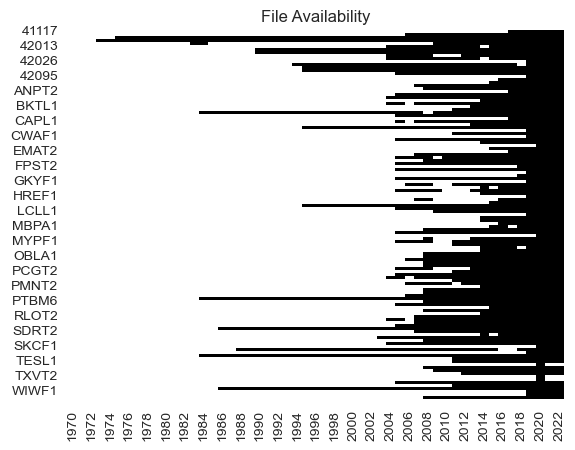

In [6]:
# Create a heatmap of the DataFrame
sns.heatmap(file_availability.astype(bool), cmap='binary', annot=False, cbar=False)
plt.title("File Availability")
plt.show()


# TODO:

# So basically, downloading the whole Gulf of Mexico data would be about 4GB!
    * Add Feature and Instance selection of File-Base

Stations = Features
Years = Instances

# Instance Selection:
* More recent data is more important for forecasting
* There must not be a gap within the data
* In this step: filter NaN data
--->
* Only Consider years where more than 50% of the stations provide files
* TODO: also consider acepting lower rate for single years if this leads to a significantly longer time period

# Feature Selection:
* Remove stations which do only provide files for less than 50% of the considered years

# Instance Selection (=filtering years)


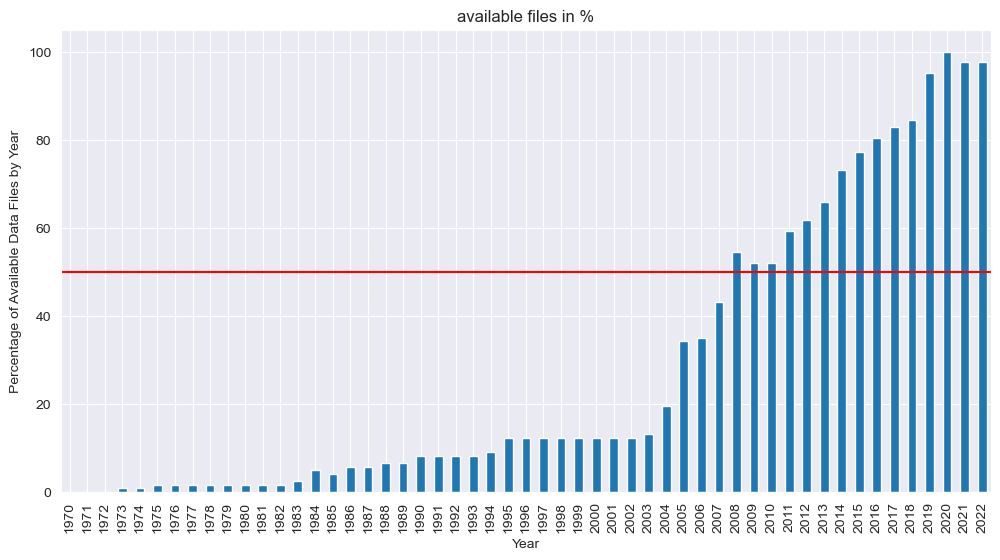

In [7]:
file_count = file_availability.sum()

# compute the percentage of True values by column
file_count_percentages = file_count / len(file_availability) * 100

# plot the results
ax = file_count_percentages.plot(kind='bar',figsize=(12,6))
plt.title('available files in %')
plt.xlabel('Year')
plt.ylabel('Percentage of Available Data Files by Year')

# add a horizontal line at 50%
ax.axhline(y=50, color='r', linestyle='-')

plt.show()

In [8]:
#This function returns a file_availability heatmap-style datafreame. The years are filtered by only considering the most recent years which provide files for more than 50% of the stations. From the remaining dataframe, all stations which do not provide  files for at least 50% of the remaining years, are removed.

#Parameter: a heatmap-style dataframe with years as columns and station names as index.
def file_based_filter(file_availability):

    #Determine first year
    file_count = file_availability.sum().sort_index(ascending=False)
    limit = file_count.max() // 2 #50%
    first_year = file_count.index[0] # most recent year
    for index, value in file_count.items():
        if value < limit:
            break
        else:
            first_year = index

    #file_availability_filtered = file_availability.loc[file_availability.columns >= first_year]
    filtered = file_availability.loc[:, [col for col in file_availability.columns if col > first_year]]

    #Filter stations which provide files for less than 50% of the remaining files
    limit = filtered.shape[1] // 2  # 50% of remaining years
    filtered = filtered[filtered.sum(axis=1) > limit]

    return filtered

In [9]:
files_filtered = file_based_filter(file_availability)
files_filtered

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
41112,True,True,True,True,True,True,True,True,True,True,True,True,True,True
42001,True,True,True,True,True,True,True,True,True,True,True,True,True,True
42002,True,True,True,True,True,True,True,True,True,True,True,True,True,True
42012,True,True,True,True,True,True,True,True,True,True,True,True,True,True
42013,True,True,True,True,True,False,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TXPT2,False,False,False,True,True,True,True,True,True,True,True,True,True,True
VCAF1,True,True,True,True,True,True,True,True,True,True,True,True,True,True
VCAT2,False,False,True,True,True,True,True,True,True,True,True,True,True,True
VENF1,True,True,True,True,True,True,True,True,True,True,True,True,True,True


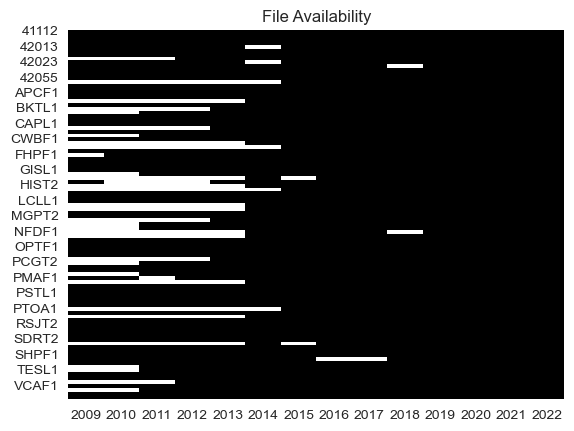

In [10]:
# Create a heatmap of the DataFrame
sns.heatmap(files_filtered.astype(bool), cmap='binary', annot=False, cbar=False)
plt.title("File Availability")
plt.show()

In [11]:
num_files = file_availability.shape[0] * file_availability.shape[1]
num_files_filtered = files_filtered.shape[0] * files_filtered.shape[1]
remaining_rate = (num_files_filtered / num_files)*100
print(f"After applying the filter {num_files_filtered} of the original {num_files} files ({round(remaining_rate, 2)} %) are remaining!")

After applying the filter 1344 of the original 6519 files (20.62 %) are remaining!


In [12]:
#def get_buoy_data(station_id, year):
#        timestamp_filter_list = mL.create_timestamp_list2(year)
#        df_NDBC = mL.get_data_file(station_id, year)
#
#        if df_NDBC is None:
#            # add empty dataframe
#            df_NDBC = pd.DataFrame(columns=[
#                  f'WDIR_{station_id}',
#                  f'WSPD_{station_id}',
#                  f'WVHT_{station_id}',
#                  f'APD_{station_id}',
#                  f'MWD_{station_id}',
#                  f'PRES_{station_id}',
#                  f'ATMP_{station_id}',
#                  f'WTMP_{station_id}',
#                  f'DEWP_{station_id}',]
#            )
#
#        else:
#            df_NDBC = mL.df_modification(df_NDBC)[1]
#            df_NDBC = mL.replace_with_NaN(df_NDBC)
#
#            #Handling duplicated index:
#            num_of_duplicates = df_NDBC.index.duplicated().sum()
#            if num_of_duplicates > 0: print(f"Found {num_of_duplicates} duplicates is {station_id}h{year} and removed them!")
#            df_NDBC = df_NDBC.loc[~df_NDBC.index.duplicated(keep='first')]
#
#            df_NDBC = df_NDBC.filter(timestamp_filter_list, axis=0)
#            df_NDBC.drop([f'GST_{station_id}',
#                          f'DPD_{station_id}',
#                          f'VIS_{station_id}',
#                          f'TIDE_{station_id}'], axis=1, inplace=True)
#
#        # some data rows are missed. Those are filled up with NaN:
#        for timestamp in timestamp_filter_list:
#            if not timestamp in df_NDBC.index:  #might must be timestamp instead of index
#                df_NDBC.loc[timestamp] = [np.NAN]*9#

#        df_NDBC.sort_index(inplace=True)
#        df_NDBC = df_NDBC.astype(float) #convert string to float
#        return df_NDBC

In [14]:
'''
STATION_LIST = [
    '41117',
    '41112',
    '42001',
    '42002',
    '42012'
]

YEARS = [
    '2019',
    '2020',
    '2021',
    '2022'
]

dataset, statistic = mL.build_NDBC_dataset(STATION_LIST, YEARS)
'''

"\nSTATION_LIST = [\n    '41117',\n    '41112',\n    '42001',\n    '42002',\n    '42012'\n]\n\nYEARS = [\n    '2019',\n    '2020',\n    '2021',\n    '2022'\n]\n\ndataset, statistic = build_NDBC_dataset(STATION_LIST, YEARS)\n"

In [15]:
station_list = files_filtered.index.tolist()
years = files_filtered.columns.tolist()

dataset, statistic = mL.build_NDBC_dataset(station_list, years)

Started with  2009 . Previous year took:   0.000965118408203125 seconds
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed t

In [16]:
dataset

,WDIR_41112,WSPD_41112,WVHT_41112,APD_41112,MWD_41112,PRES_41112,ATMP_41112,WTMP_41112,DEWP_41112,WDIR_42001,...,DEWP_VENF1,WDIR_WYCM6,WSPD_WYCM6,WVHT_WYCM6,APD_WYCM6,MWD_WYCM6,PRES_WYCM6,ATMP_WYCM6,WTMP_WYCM6,DEWP_WYCM6
2009-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,0.92,5.43,117.0,NaN,16.1,13.2,NaN,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,0.94,5.18,117.0,NaN,16.7,13.2,NaN,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,0.92,5.05,105.0,NaN,15.7,13.3,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,0.88,5.42,114.0,NaN,15.7,13.3,NaN,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
statistic

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
41112,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,0.945102,0.581862,0.576636,0.563775,0.593440,0.467390,0.451865
42001,1.000000,1.000000,1.000000,1.000000,1.000000,1,0.944673,1.000000,0.547996,0.518379,0.628678,0.711015,0.827689,0.750989
42002,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,0.870573,0.405156,0.445700,0.469051
42012,1.000000,0.999975,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,0.581900,0.518924,0.389192,0.549937,0.495662
42013,0.634703,0.791578,0.790893,0.907762,0.997286,1,0.808371,0.680821,0.727385,0.630771,0.550799,0.536746,0.618493,0.780581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TXPT2,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
VCAF1,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
VCAT2,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
VENF1,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


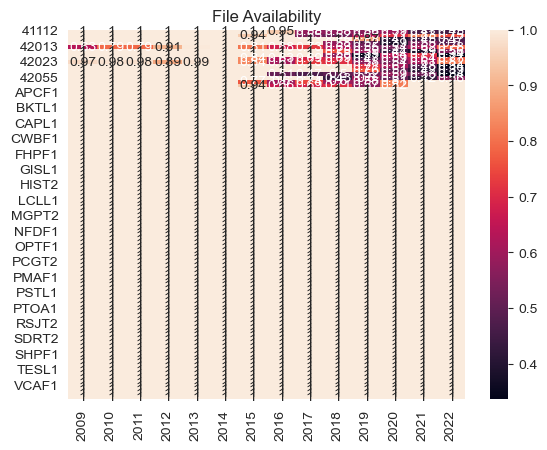

In [18]:
# Create a heatmap of the DataFrame
sns.heatmap(statistic.astype(float), annot=True, cbar=True)

plt.title("File Availability")
plt.show()

In [ ]:
filename = "dataset_GOM_1"
dataset.to_csv(f'../data/datasets/{filename}_NDBC.csv', index=True)

<AxesSubplot:>

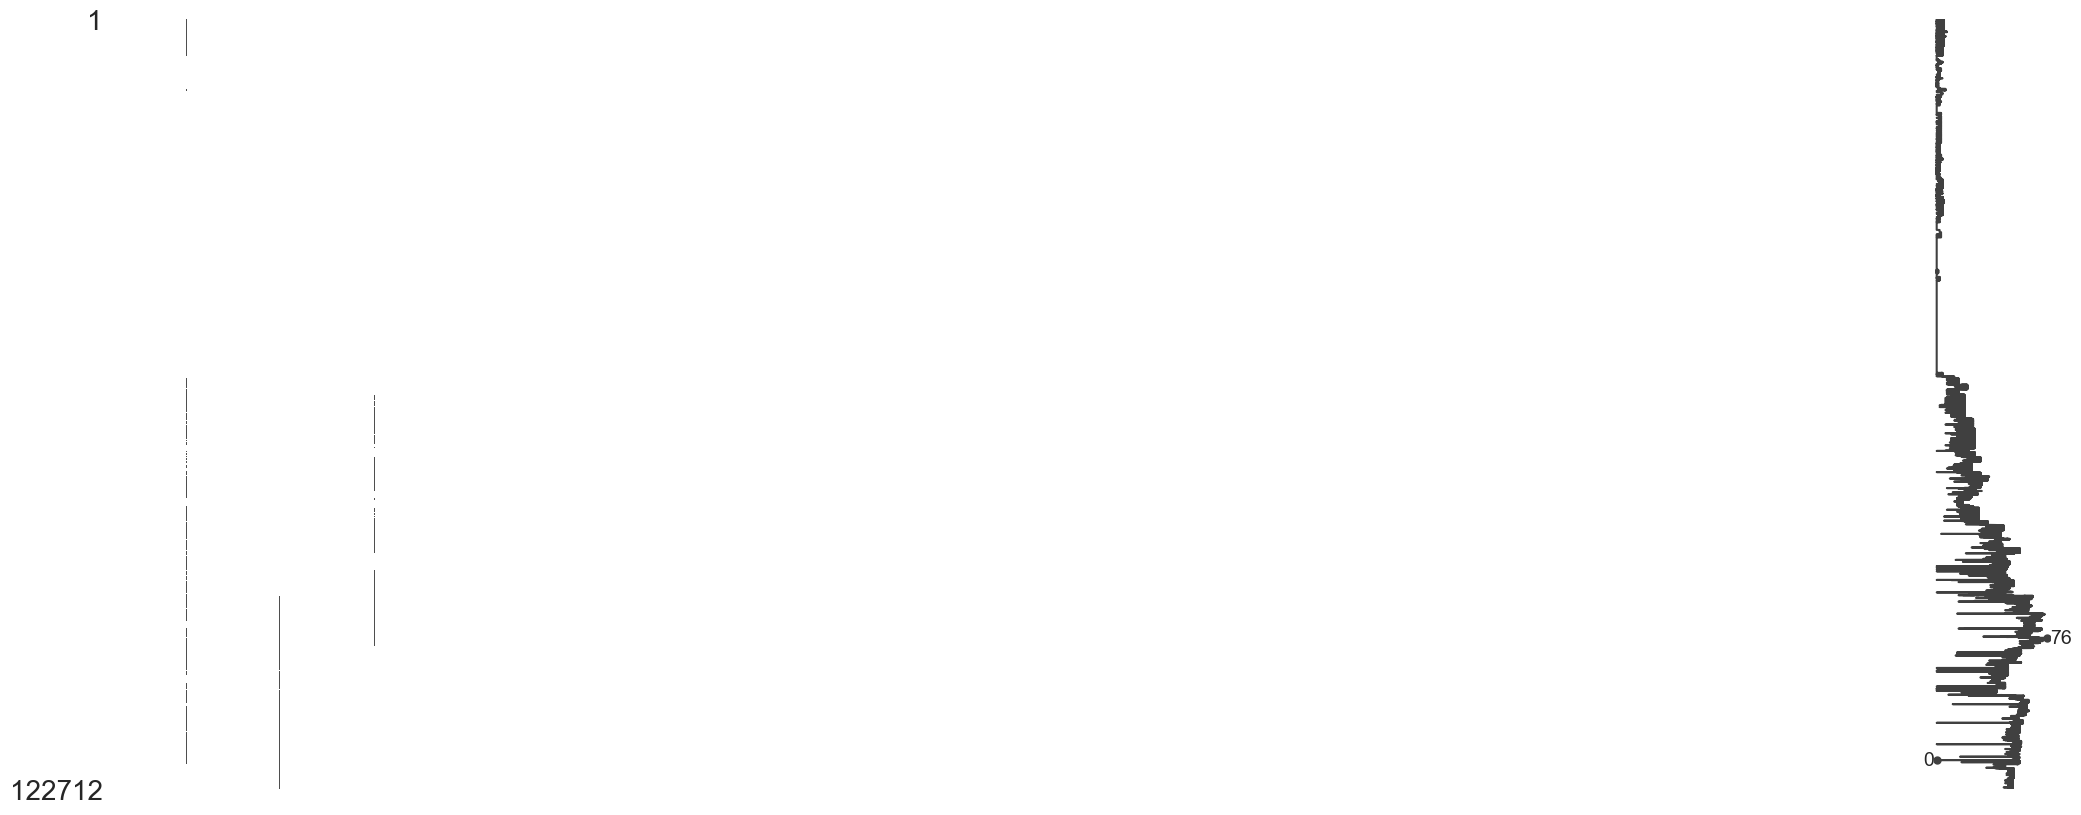

In [17]:
import missingno as msno
msno.matrix(dataset)

---
# Build ERA5 dataset

In [ ]:
# Note:
# it would also be possible to download several years in one step by changing the "year" parameter in mL.download_ERA5_singlePoint(). I decided to seperate them by years with the goal to get low redundance when storing data.

def build_ERA5_dataset(STATION_LIST, YEARS):
    data_list_annual = list()    # each element in this list is a df containing data of one certain year and all stations
    for year in YEARS:

        ERA5_data_list = list() # each element in this list is a df containing data of one certain year and one certain station.
        for station in STATION_LIST:
            ERA5_data = mL.get_ERA5_singlePoint(station, year)  # load file
            ERA5_data_list.append(ERA5_data)

        merged_ERA5_data = pd.concat(ERA5_data_list, axis=1, join="outer")  # outer join also includes NaN, inner join removes them
        data_list_annual.append(merged_ERA5_data)

    dataset_NDBC = pd.concat(data_list_annual, axis=0)
    return dataset_NDBC

In [ ]:
#df_ERA5 = mL.get_ERA5_singlePoint('venf1', '2020') # this is just a test

In [ ]:
dataset_ERA5 = build_ERA5_dataset(STATION_LIST, YEARS)

#TODO: change directory to data/datasets/...
#dataset_ERA5.to_csv(f'datasets/{filename}_ERA5.csv', index=False)
dataset_ERA5